# import packages

- ID-  테스트 세트 내의 (Shop, Item) 튜플을 나타내는 Id
- shop_id- 상점의 고유 식별자
- item_id- 상품의 고유 식별자
- item_category_id- 항목 카테고리의 고유 식별자
- item_cnt_day- 판매 된 제품 수입니다. 이 측정 값의 월별 금액을 예측하고 있습니다.
- item_price- 상품의 현재 가격
- date  -dd / mm / yyyy 형식의 날짜
- date_block_num- 편의를 위해 사용되는 연속 월 번호입니다. 2013 년 1 월은 0, 2013 년 2 월은 1, ..., 2015 년 10 월은 33입니다.
- item_name-  항목 이름
- shop_name- 상점 이름
- item_category_name- 항목 카테고리 이름

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt # 시각화
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler # 표준화, 정규화
from sklearn.preprocessing import LabelEncoder, OneHotEncoder # 인코더
from sklearn.metrics import mean_squared_error
from sklearn import metrics

# data 전처리

In [2]:
!cd

C:\Users\j\kaggle_predict_sale


In [3]:
df_train = pd.read_csv('competitive-data-science-predict-future-sales/sales_train.csv')

In [4]:
df_test = pd.read_csv('competitive-data-science-predict-future-sales/test.csv')

In [5]:
df_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [6]:
df_test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [7]:
df_train.describe().round()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2935849.0,2935849.0,2935849.0,2935849.0,2935849.0
mean,15.0,33.0,10197.0,891.0,1.0
std,9.0,16.0,6324.0,1730.0,3.0
min,0.0,0.0,0.0,-1.0,-22.0
25%,7.0,22.0,4476.0,249.0,1.0
50%,14.0,31.0,9343.0,399.0,1.0
75%,23.0,47.0,15684.0,999.0,1.0
max,33.0,59.0,22169.0,307980.0,2169.0


In [8]:
df_train.drop(['date_block_num','item_price'], axis=1, inplace=True)
# 월번호, 상품 현재가격 드랍
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 4 columns):
 #   Column        Dtype  
---  ------        -----  
 0   date          object 
 1   shop_id       int64  
 2   item_id       int64  
 3   item_cnt_day  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 89.6+ MB


In [9]:
print(df_train['shop_id'])  # 상점의 고유식별자 확인

0          59
1          25
2          25
3          25
4          25
           ..
2935844    25
2935845    25
2935846    25
2935847    25
2935848    25
Name: shop_id, Length: 2935849, dtype: int64


In [10]:
# 날짜 인코딩

df_train['date'] = pd.to_datetime(df_train['date'], dayfirst=True)

In [11]:
df_train['date'].head()

0   2013-01-02
1   2013-01-03
2   2013-01-05
3   2013-01-06
4   2013-01-15
Name: date, dtype: datetime64[ns]

In [12]:
# 월별 데이터로 인코딩
df_train['date'] = df_train['date'].apply(lambda x: x.strftime('%Y-%m'))
df_train.head()

,date,shop_id,item_id,item_cnt_day
0,2013-01,59,22154,1.0
1,2013-01,25,2552,1.0
2,2013-01,25,2552,-1.0
3,2013-01,25,2554,1.0
4,2013-01,25,2555,1.0


In [13]:
X = df_train.groupby(['date','shop_id','item_id']).sum()

In [14]:
X

item_cnt_day
date    shop_id item_id              
2013-01 0       32                6.0
                33                3.0
                35                1.0
                43                1.0
                51                2.0
...                               ...
2015-10 59      22087             6.0
                22088             2.0
                22091             1.0
                22100             1.0
                22102             1.0

[1609124 rows x 1 columns]

In [15]:
X = X.pivot_table(index=['shop_id','item_id'], columns='date', values='item_cnt_day', fill_value=0)
X.reset_index(inplace=True)
X.head()

date,shop_id,item_id,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,...,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10
0,0,30,0,31,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,31,0,11,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,32,6,10,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,33,3,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,35,1,14,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
X_t = pd.merge(df_test, X, on=['shop_id','item_id'], how='left') # left join
X_t.drop(['ID'], axis=1, inplace=True) # id 값 삭제

In [17]:
u = X_t.select_dtypes(exclude=['datetime'])

In [18]:
u

,shop_id,item_id,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,...,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10
0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,5,5320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,5,5268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,45,18454,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
214196,45,16188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
214197,45,15757,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214198,45,19648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
X_t[u.columns] = u.fillna(0) # 결측치를 0으로 초기화
X_t.head()

,shop_id,item_id,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,...,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10
0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
Y = X['2015-10'].values  # 독립변수 15년 10월달의 아이템 개수
X_T = X.drop(['2015-10'], axis = 1) # train 독립변수
X_t = X_t.drop(['2015-10'], axis = 1) # test 독립변수
print(X_T.shape, Y.shape)
print(X_t.shape)

(424124, 35) (424124,)
(214200, 35)


# 상관 분석

<AxesSubplot:>

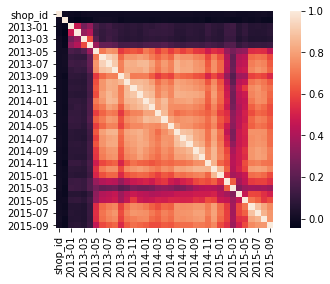

In [21]:
corrmat = X_t.corr()  # 독립변수간의 상관성 확인
sns.heatmap(corrmat,square= True)

In [22]:
k = 35
cols = corrmat.nlargest(k, '2015-09')['2015-09'].index  # 값이 높은 k번째까지 출력

In [24]:
cols

Index(['2015-09', '2015-08', '2015-07', '2015-06', '2014-12', '2014-09',
       '2014-10', '2014-11', '2013-11', '2014-08', '2014-07', '2014-06',
       '2013-08', '2013-12', '2014-01', '2014-04', '2013-07', '2013-10',
       '2014-05', '2014-03', '2014-02', '2015-01', '2015-05', '2013-06',
       '2015-02', '2013-09', '2015-04', '2013-05', '2015-03', '2013-04',
       '2013-02', '2013-01', '2013-03', 'shop_id', 'item_id'],
      dtype='object')

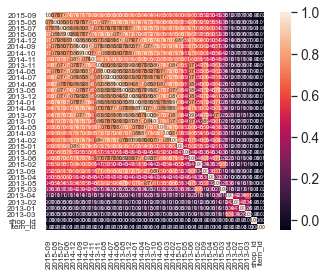

In [25]:
cm = np.corrcoef(X_t[cols].values.T)  # 상관계수 행렬 반환
# https://kr.mathworks.com/help/matlab/ref/corrcoef.html
sns.set(font_scale=1.25) # 시각화 폰트크기 설정
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 5},yticklabels=cols.values, xticklabels=cols.values)
plt.tick_params(labelsize=8)
plt.show()

# 모델링 및 예측

- ## MAE(Mean Absolute Error)
    - 실제 값과 예측 값의 차이(Error)를 절대값으로 변환해 평균화

- MAE는 에러에 절대값을 취하기 때문에 에러의 크기 그대로 반영된다. 그러므로 예측 결과물의 에러가 10이 나온 것이 5로 나온 것보다 2배가 나쁜 도메인에서 쓰기 적합한 산식이다.

- 에러에 따른 손실이 선형적으로 올라갈 때 적합하다.
- 이상치가 많을 때

- ## MSE (Mean Squared Error)
    - 실제 값과 예측 값의 차이를 제곱해 평균화

- 예측값과 실제값 차이의 면적의 합

- 특이값이 존재하면 수치가 많이 늘어난다.

- ## RMSE (Root Mean Squared Error)
    - MSE 값은 오류의 제곱을 구하므로 실제 오류 평균보다 더 커지는 특성이 있어 MSE에 루트를 씌운 RMSE 값을 쓴다.

- 에러에 제곱을 하기 때문에 에러가 크면 클수록 그에 따른 가중치가 높이 반영된다. 그러므로 예측 결과물의 에러가 10이 나온 것이 5로 나온 것보다, 정확히 2^2(4)배가 나쁜 도메인에서 쓰기 적합한 산식이다.

- 에러에 따른 손실이 기하 급수적으로 올라가는 상황에서 쓰기 적합하다.

In [26]:
# 성능 특성 지표 확인
# https://mizykk.tistory.com/102 참조
def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)  # 상관계수 확인
    print('__________________________________')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

In [27]:
# test 데이터, train 데이터 분할
x_train, x_val, y_train, y_val = train_test_split(X_T, Y, test_size=0.2, random_state=3)
print(x_train.shape,y_train.shape)
print(x_val.shape,y_val.shape)

(339299, 35) (339299,)
(84825, 35) (84825,)


In [28]:
# 랜덤 포레스트 회귀분석 시작
RF_reg = RandomForestRegressor(n_estimators = 100) # 100개의 트리를 생성
RF_reg.fit(x_train, y_train)

RandomForestRegressor()

In [29]:
val_pred = RF_reg.predict(x_val)
train_pred = RF_reg.predict(x_train)
print(val_pred)
print(train_pred)
print_evaluate(y_val, val_pred)
print_evaluate(y_train, train_pred)

[0.  0.  0.  ... 0.1 0.  0. ]
[0.   0.08 0.   ... 0.66 0.01 0.  ]
MAE: 0.16201638667845564
MSE: 1.4638772720306512
RMSE: 1.2099079601484781
R2 Square 0.6011336206885383
__________________________________
MAE: 0.06466726987111662
MSE: 2.3393869531003624
RMSE: 1.5295054603042
R2 Square 0.877819525838435
__________________________________


In [30]:
test_pred = RF_reg.predict(X_t)
print('prediction for test data:',test_pred)
print(test_pred.shape)

prediction for test data: [0.14 0.84 0.94 ... 0.04 0.96 0.05]
(214200,)


[[     0      5   5037]
 [     1      5   5320]
 [     2      5   5233]
 ...
 [214197     45  15757]
 [214198     45  19648]
 [214199     45    969]]
[0.14 0.84 0.94 ... 0.04 0.96 0.05]


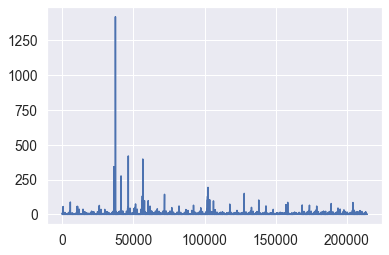

In [31]:
x = np.array(df_test)
print(x)
print(test_pred)
plt.plot(x[:,0:1],test_pred)
plt.show()

# 결과(Sumission)

In [32]:
submission = pd.DataFrame({
    'ID':df_test['ID'],
    'item_cnt_month':test_pred
})
submission.to_csv('submission.csv', index=False)
print(submission)
submission.head()

            ID  item_cnt_month
0            0            0.14
1            1            0.84
2            2            0.94
3            3            0.06
4            4            0.84
...        ...             ...
214195  214195            0.63
214196  214196            1.03
214197  214197            0.04
214198  214198            0.96
214199  214199            0.05

[214200 rows x 2 columns]


,ID,item_cnt_month
0,0,0.14
1,1,0.84
2,2,0.94
3,3,0.06
4,4,0.84


In [23]:
!cd

C:\Users\j\kaggle_predict_sale
